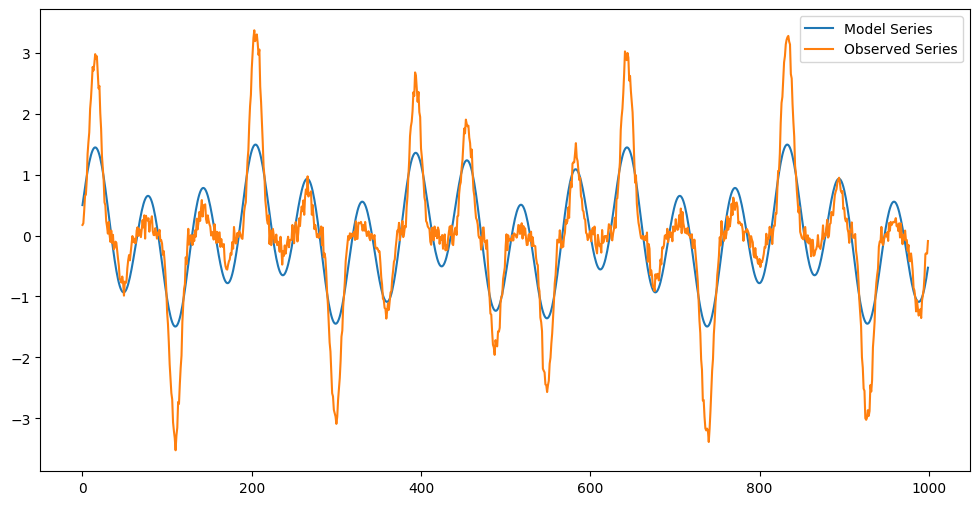

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры
np.random.seed(42)
n = 1000  # длина ряда
t = np.arange(n)

# Модельный ряд
model_series = np.sin(0.1 * t) + 0.5 * np.cos(0.03 * t)

# Наблюдаемый сигнал (нелинейное преобразование + шум)
observed_series = model_series**3 + np.random.normal(0, 0.1, n)

plt.figure(figsize=(12, 6))
plt.plot(t, model_series, label='Model Series')
plt.plot(t, observed_series, label='Observed Series')
plt.legend()
plt.show()


In [2]:
MODEL_SERIES_INPUT_SIZE = 4
OBSERVED_SERIES_INPUT_SIZE = 4

from sklearn.model_selection import train_test_split

def make_Xy(series, input_size):
    X, y = [], []
    for i in range(len(series) - input_size):
        X.append(series[i:i+input_size])
        y.append(series[i+input_size])
    return np.array(X), np.array(y)

X_model, y_model = make_Xy(model_series, MODEL_SERIES_INPUT_SIZE)
X_observed, y_observed = make_Xy(observed_series, OBSERVED_SERIES_INPUT_SIZE)

 

In [3]:
# make train-test-val split
# model series
X_model_train, X_model_test, y_model_train, y_model_test = train_test_split(X_model, y_model, test_size=0.4, random_state=42, shuffle=False)
X_model_val, X_model_test, y_model_val, y_model_test = train_test_split(X_model_test, y_model_test, test_size=0.7, random_state=42, shuffle=False)

# observed series
X_observed_train, X_observed_test, y_observed_train, y_observed_test = train_test_split(X_observed, y_observed, test_size=0.4, random_state=42, shuffle=False)
X_observed_val, X_observed_test, y_observed_val, y_observed_test = train_test_split(X_observed_test, y_observed_test, test_size=0.7, random_state=42, shuffle=False)

In [4]:
# model+observed series for input
X_train = np.concatenate([X_model_train, X_observed_train], axis=1)
X_val = np.concatenate([X_model_val, X_observed_val], axis=1)
X_test = np.concatenate([X_model_test, X_observed_test], axis=1)

# model+observed series for output
y_train = y_model_train
y_val = y_model_val
y_test = y_model_test

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(597, 8) (597,)
(119, 8) (119,)
(280, 8) (280,)


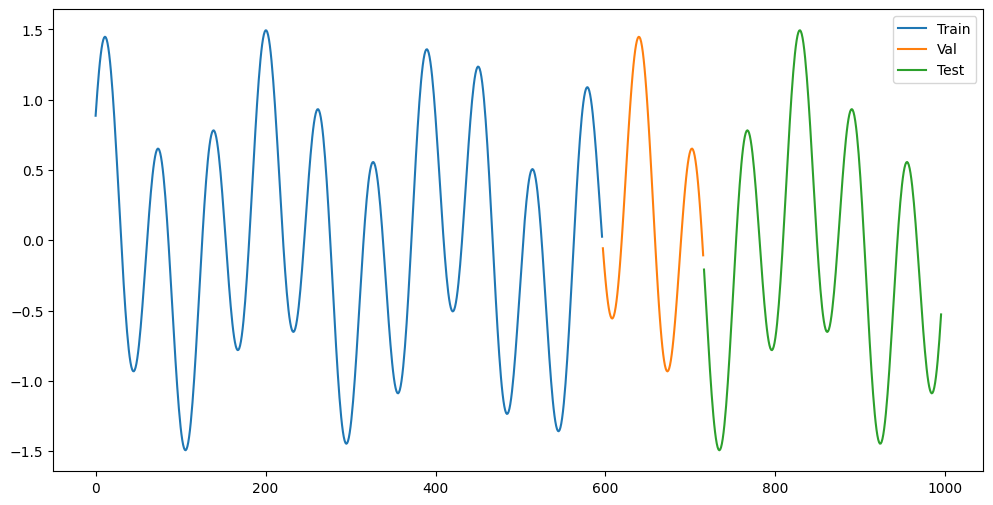

In [5]:
# plot train-val-test split
plt.figure(figsize=(12, 6))
plt.plot(t[:len(y_model_train)], y_model_train, label='Train')
plt.plot(t[len(y_model_train):len(y_model_train)+len(y_model_val)], y_model_val, label='Val')
plt.plot(t[len(y_model_train)+len(y_model_val):len(y_model_train)+len(y_model_val)+len(y_model_test)], y_model_test, label='Test')
plt.legend()
plt.show()


In [6]:
# define the NARX model
import torch
import torch.nn as nn

class NARX(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARX, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        
    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = self.fc2(out)
        return out
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training loop

def train_model(model, X_train, y_train, X_val, y_val, n_epochs=1000, lr=0.1):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            model.eval()
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
            val_loss = criterion(model(X_val_tensor), y_val_tensor)
            print(f'Epoch {epoch}, Loss {loss.item():.4f}, Val Loss {val_loss.item():.4f}')
            
    return model

# train the model
model = NARX(input_size=MODEL_SERIES_INPUT_SIZE+OBSERVED_SERIES_INPUT_SIZE, hidden_size=64, output_size=1)


In [20]:
model(torch.from_numpy(X_train[10:20]).float().cuda())

tensor([[0.0061],
        [0.0087],
        [0.0087],
        [0.0058],
        [0.0080],
        [0.0058],
        [0.0064],
        [0.0112],
        [0.0074],
        [0.0075]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [15]:
y_train[:10]

array([0.88582266, 0.97381108, 1.05656432, 1.13323314, 1.20302508,
       1.26521236, 1.31913923, 1.36422853, 1.3999875 , 1.42601272])

c:\Users\waclo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([597])) that is different to the input size (torch.Size([597, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\waclo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([119])) that is different to the input size (torch.Size([119, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss 0.6716, Val Loss 0.6000
Epoch 100, Loss 0.6482, Val Loss 0.5183
Epoch 200, Loss 0.6482, Val Loss 0.5183
Epoch 300, Loss 0.6482, Val Loss 0.5183
Epoch 400, Loss 0.6482, Val Loss 0.5183
Epoch 500, Loss 0.6482, Val Loss 0.5183
Epoch 600, Loss 0.6482, Val Loss 0.5183
Epoch 700, Loss 0.6482, Val Loss 0.5183
Epoch 800, Loss 0.6482, Val Loss 0.5182
Epoch 900, Loss 0.6482, Val Loss 0.5182


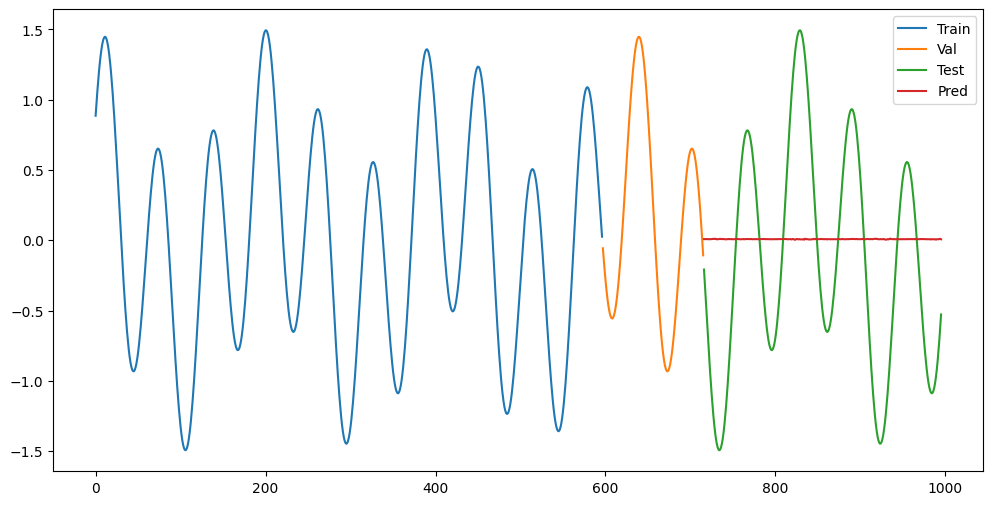

In [17]:

model = train_model(model, X_train, y_train, X_val, y_val, n_epochs=1000, lr=0.01)

# predict
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_pred = model(X_test_tensor).cpu().detach().numpy()

# plot the results
plt.figure(figsize=(12, 6))
plt.plot(t[:len(y_model_train)], y_model_train, label='Train')
plt.plot(t[len(y_model_train):len(y_model_train)+len(y_model_val)], y_model_val, label='Val')
plt.plot(t[len(y_model_train)+len(y_model_val):len(y_model_train)+len(y_model_val)+len(y_model_test)], y_model_test, label='Test')
plt.plot(t[len(y_model_train)+len(y_model_val):len(y_model_train)+len(y_model_val)+len(y_model_test)], y_pred, label='Pred')
plt.legend()
plt.show()

        